<a href="https://colab.research.google.com/github/MythEclipse/Belajar-MachineLearning/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Asep haryana saputra

In [ ]:
import tensorflow as tf
import urllib.request
import zipfile
import re
import os
from tensorflow.keras.utils import get_file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Bidirectional,Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,GRU,GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('BA_AirlineReviews.csv')

In [ ]:
df = df[['ReviewHeader', 'ReviewBody', 'Recommended']]
df = df.dropna(subset=['ReviewHeader', 'ReviewBody', 'Recommended'])
df['Recommended'] = df['Recommended'].apply(lambda x: 1 if x.lower() == 'yes' else 0)


In [ ]:
print(df.info())
print(df.head())
print(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ReviewHeader   3701 non-null   object
 1   ReviewBody     3701 non-null   object
 2   Recommended    3701 non-null   int64 
 3   ProcessedText  3701 non-null   object
dtypes: int64(1), object(3)
memory usage: 115.8+ KB
None
                               ReviewHeader  \
0    "Service level far worse then Ryanair"   
1  "do not upgrade members based on status"   
2             "Flight was smooth and quick"   
3             "Absolutely hopeless airline"   
4        "Customer Service is non existent"   

                                          ReviewBody  Recommended  \
0  4 Hours before takeoff we received a Mail stat...            0   
1  I recently had a delay on British Airways from...            0   
2  Boarded on time, but it took ages to get to th...            1   
3  5 days before the

In [ ]:
print(df.columns)


Index(['ReviewHeader', 'ReviewBody', 'Recommended'], dtype='object')


In [ ]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

df['ProcessedText'] = df['ReviewHeader'] + ' ' + df['ReviewBody']
df['ProcessedText'] = df['ProcessedText'].apply(remove_punctuation)
df['ProcessedText'] = df['ProcessedText'].apply(preprocess_text)

In [ ]:
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df['ProcessedText'])
sequences = tokenizer.texts_to_sequences(df['ProcessedText'])
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Recommended'].values, test_size=0.2, random_state=42)


In [ ]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(80,kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=5,mode='max', verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
]

In [ ]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test),batch_size=128,callbacks=[callbacks])


Epoch 1/100
24/24 [==============================] - 10s 300ms/step - loss: 1.3496 - accuracy: 0.5821 - val_loss: 1.1423 - val_accuracy: 0.6019
Epoch 2/100
24/24 [==============================] - 5s 199ms/step - loss: 1.0210 - accuracy: 0.5905 - val_loss: 0.8995 - val_accuracy: 0.6113
Epoch 3/100
24/24 [==============================] - 5s 222ms/step - loss: 0.8053 - accuracy: 0.6294 - val_loss: 0.6542 - val_accuracy: 0.7476
Epoch 4/100
24/24 [==============================] - 5s 220ms/step - loss: 0.5497 - accuracy: 0.8182 - val_loss: 0.5164 - val_accuracy: 0.7908
Epoch 5/100
24/24 [==============================] - 5s 201ms/step - loss: 0.3490 - accuracy: 0.9017 - val_loss: 0.3929 - val_accuracy: 0.8691
Epoch 6/100
24/24 [==============================] - 6s 272ms/step - loss: 0.2297 - accuracy: 0.9419 - val_loss: 0.5908 - val_accuracy: 0.8516
Epoch 7/100
24/24 [==============================] - 5s 189ms/step - loss: 0.1742 - accuracy: 0.9598 - val_loss: 0.3398 - val_accuracy: 0.862

In [ ]:
train_accuracy = history.history['accuracy'][-1]
test_accuracy = history.history['val_accuracy'][-1]
print(f'Train Accuracy: {train_accuracy*100:.2f}%')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')


Train Accuracy: 99.02%
Test Accuracy: 85.16%


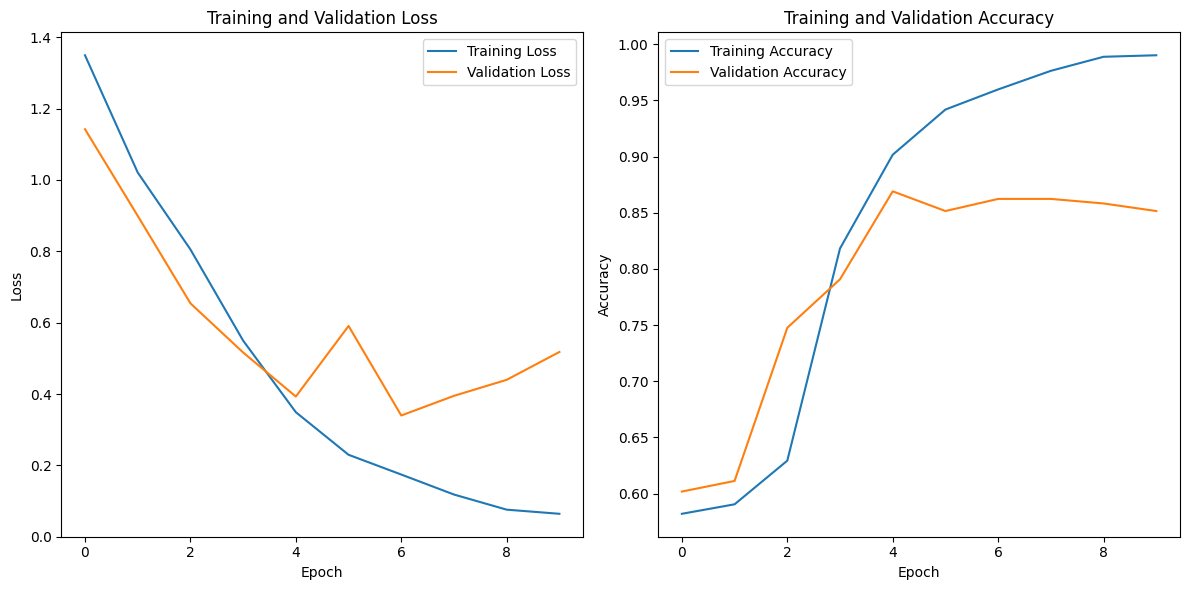

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()